# Testing EOF decomposition with dask using `xeofs` package

In progress work using the `xeofs` package to analyze multi-decadal SST variability on a local machine. Data are accessed using `earthaccess` package.

Ultimately want to perform an analysis such as: https://doi.org/10.1175/2011JCLI3941.1 

Which uses the dataset: https://podaac.jpl.nasa.gov/dataset/REYNOLDS_NCDC_L4_MONTHLY_V5

Thise notebook is meant to be run as a Coiled Notebook, see docs here: https://docs.coiled.io/user_guide/usage/notebooks/index.html#notebook-file-sync 

Additional reference used for EOF analysis: https://github.com/royalosyin/Python-Practical-Application-on-Climate-Variability-Studies/blob/master/ex18-EOF%20analysis%20global%20SST.ipynb

Because the time variable in this dataset is non-conventional, the `cftime` package is required to decode the timestamps using `Xarray`.

Although the above study uses the time period 1910 to 2009, we instead use 1910 to 2008, since the data providers of the dataset changed the time format from 2008 onward and xarray doesn't like it.

## 1. Access and load data

***Need latest versions (as of October 2023) of all the below packages to ensure this notebook works***

In [1]:
import earthaccess
import s3fs
import xarray as xr
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from cartopy.crs import EqualEarth, PlateCarree
import xeofs as xe
from eofs.standard import Eof
import coiled

%matplotlib inline

In [2]:
earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
No .netrc found in /home/mambauser


Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/21/2023
Using user provided credentials for EDL


In [3]:
%%time

endpoints = earthaccess.search_data(
    short_name="REYNOLDS_NCDC_L4_MONTHLY_V5",
    cloud_hosted=True,
    temporal=("1910-01-01", "2008-02-01"),
    )

Granules found: 1178
CPU times: user 252 ms, sys: 3.81 ms, total: 256 ms
Wall time: 24 s


In [4]:
%%time

fileobjs = earthaccess.open(endpoints)

 Opening 1178 granules, approx size: 0.12 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1178 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1178 [00:00<?, ?it/s]

CPU times: user 1.86 s, sys: 91.3 ms, total: 1.95 s
Wall time: 5.24 s


**Found a weird result in one of the file objects:**

In [5]:
fileobjs_bad = [f for f in fileobjs if type(f) == FileNotFoundError]
print(fileobjs_bad)

[FileNotFoundError('podaac-ops-cumulus-protected/REYNOLDS_NCDC_L4_MONTHLY_V5/ersst.v5.195908.nc.1')]


**The above file does not show up in CMR: https://cmr.earthdata.nasa.gov/virtual-directory/collections/C2036878116-POCLOUD/temporal**

This is worth looking into, but for now just remove this object from the list and continue:

In [6]:
fileobjs_good = [f for f in fileobjs if type(f) != FileNotFoundError]

In [7]:
print(len(fileobjs))
print(len(fileobjs_good))

1178
1177


**Further weirdness with earthaccess. Somehow the 190912 file was found even though timebounds starting at 191001 were asked for, so remove the 190912 file:**

In [8]:
fileobjs_good = fileobjs_good[1:]

In [9]:
%%time

# The runtime of this line can be decreased using parallelization:
sstdata = xr.open_mfdataset(fileobjs_good, chunks={})
#sstdata = xr.open_mfdataset(fileobjs_good[:50], chunks={})

CPU times: user 37.4 s, sys: 466 ms, total: 37.9 s
Wall time: 3min 33s


In [10]:
sstdata = sstdata.squeeze()
sstdata

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 1176)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
    lev      float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1910-01-01 00:00:00 ... 2007-12-01 00:00:00
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
    ssta     (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.191001
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    ...                         ...
    platform:                   Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    instrument:                 Conventional thermometers
    source:                     In situ data: ICOADS R3.0 before 2015, NCEP i...
    comment:                    SSTs were observed by conventional thermomete...
    references:                 Huang et al, 2017: Extended Reconstructed Sea...
    climatology:                Climatology is based on 1971-2000 SST, Xue, Y...

## 2. Detrend and Remove Seasonal Cycle

**Future updates**
* Try using Xarray's version of Polyfit: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.polyfit.html
* Try using Xarray's groupby to compute mean seasonal cycle: https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html

In [11]:
# Remove data poleward of 65 degress lat (copying the publication):
sstdata = sstdata.sel(lat=slice(-65, 65))

### 2.1 Linear Detrend

Options:
* np.polyfit()
* scipy.signal.detrend()

**For each lat, lon gridpoint, the data across all timestamps are either (1) all nan's or (2) no nan's. The following code verifies this:**

In [12]:
nt, nlat, nlon = sstdata['sst'].shape

In [13]:
n_null = sstdata['sst'].isnull().sum(axis=0).compute().values.flatten()

In [14]:
n_nonan = (n_null == 0).sum() # Either no NANs
n_allnan = (n_null == nt).sum() # Or all NANs
len(n_null) == (n_nonan + n_allnan) # True if all gridpoints contain either all or no NANs.

True

**Because the data have nan's in this way, the following linear detrend method is used:**

NumPy method:

In [52]:
x = np.arange(nt)
sst_detrend = sstdata['sst'].values.reshape(nt, nlat*nlon)

In [53]:
# Save some data to test the detrend algorithm:
idx_detrendtest = [3500, 7000, 8000, 10000]
#test_detrend = sst_detrend[:,idx_detrendtest]
test_detrend = sst_detrend

In [54]:
# Save index locations of elements which are NAN, replace them with 0 for now:
boolar_isnan = np.isnan(sst_detrend)
sst_detrend[boolar_isnan] = 0

In [55]:
# Perform linear fit and subtract from data:
fitresults = np.polyfit(x, sst_detrend, 1, rcond=None, full=False, w=None, cov=False)
lintrend = np.multiply.outer(fitresults[0], x).T + fitresults[1]
sst_detrend = sst_detrend - lintrend

In [56]:
# Re-instert NANs:
sst_detrend[boolar_isnan] = np.nan

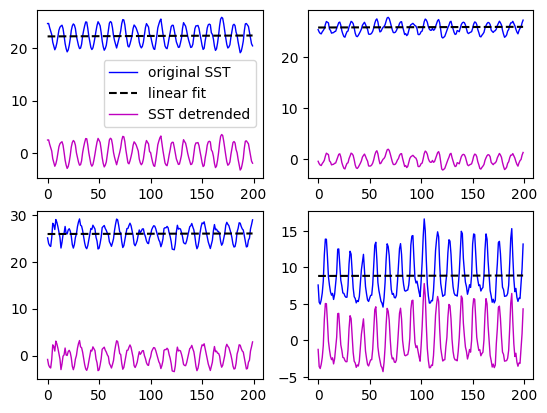

In [57]:
# Confirm detrend:
fig1, axes1 = plt.subplots(2, 2)
for ax, i in zip(axes1.flatten(), idx_detrendtest):
    ax.plot(test_detrend[:200,i], 'b-', linewidth=1, label='original SST')
    ax.plot(lintrend[:200, i], 'k--', label='linear fit')
    ax.plot(sst_detrend[:200,i], 'm-', linewidth=1, label='SST detrended')
axes1[0,0].legend()

In [120]:
# Alternate option using scipy.signal.detrend. Not sure yet if this will work with dask:
#from scipy.signal import detrend
#sst_detrend = signal.detrend(sst_detrend, axis=0, type='linear', bp=0)

### 2.2 Remove Seasonal Cycle

***Try xarray's groupby feature***

In [58]:
sst_detrend = sst_detrend.reshape((int(nt/12), 12, nlat, nlon), order='C')

In [59]:
# Average seasonal cycle over all years:
sst_seasonal = sst_detrend.mean(axis=0)

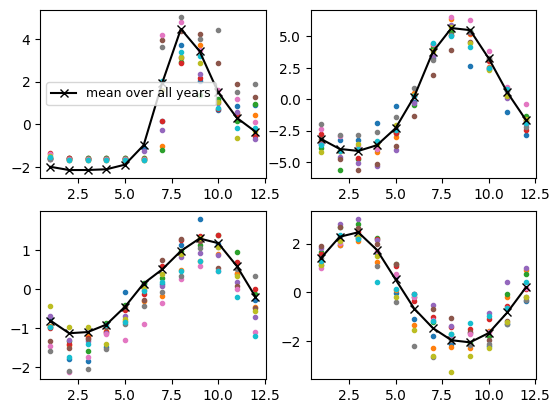

In [62]:
# Tets plot of seasonal cycle and in several lat, lon locations, along with mean cycle:
xdummy =np.arange(1,13)

fig2, axes2 = plt.subplots(2, 2)

idx_seasonaltest = [(60, 150), (50, 100), (40, 90), (20, 160)] # lat,lon index pairs in sst_detrend
for ax, ii in zip(axes2.flatten(), idx_seasonaltest):
    for j in range(10): # Plot seasonal cycle for first 10 years
        ax.scatter(xdummy, sst_detrend[j, :, *ii], marker='.')
    ax.plot(xdummy, sst_seasonal[:, *ii], color='k', marker='x', label='mean over all years')
axes2[0,0].legend(fontsize=9)

In [50]:
sst_detrend = sst_detrend - sst_seasonal
sst_detrend.shape

(98, 12, 65, 180)

In [63]:
# # Test plot of seasonal cycle and its subtraction at several gridpoint locations:
# fig3, axes3 = plt.subplots(2, 2)

# for ax, ii in zip(axes3.flatten(), idx_seasonaltest):
#     ax.plot(xdummy, sst_seasonal[:, *ii], color='k', marker='x')
#     for j in range(10): # Plot seasonal cycle for first 10 years
#         ax.scatter(xdummy, sst_detrend[j, :, *ii], marker='.')

In [66]:
sst_detrend = sst_detrend.reshape(nt, nlat, nlon, order='C')

In [67]:
sst_detrend.shape

(1176, 65, 180)

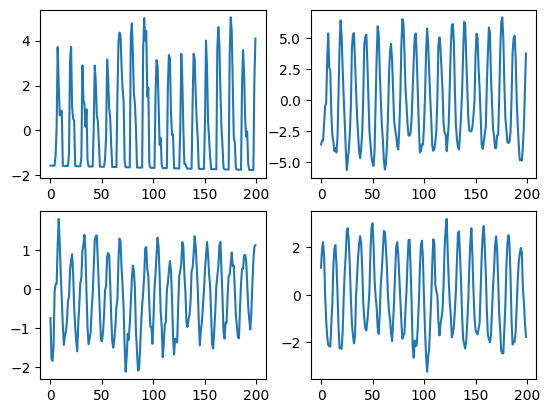

In [69]:
# Test plot of seasonal cycle removal at several gridpoint locations:
fig3, axes3 = plt.subplots(2, 2)

for ax, ii in zip(axes3.flatten(), idx_seasonaltest):
    ax.plot(sst_detrend[:200, *ii])
    #ax.plot(xdummy, sst_seasonal[:, *ii], color='k', marker='x')
    #for j in range(10): # Plot seasonal cycle for first 10 years
        #ax.scatter(xdummy, sst_detrend[j, :, *ii], marker='.')


### *!!Start extra code temporarily (don't run as part of test yet)!!*

In [227]:
# r = nt % 12

# if r == 0:
#     nt_temp = nt
# else:
#     nanpad = np.ones([12-r, nlat*nlon])*np.nan
#     nt_temp = nt + (12-r)
#     sst_detrend = np.append(sst_detrend, nanpad, axis=0)

### *!!End extra code temporarily (don't run as part of test yet)!!*

In [228]:
sst_detrend_xa = xr.DataArray(
    data=sst_detrend,
    dims=['time', 'lat', 'lon'],
    coords=dict(
        lon=sstdata['lon'],
        lat=sstdata['lat'],
        time=sstdata['time']
    ),
    #attrs=dict(
    #    description="Ambient temperature.",
    #    units="degC",
    #),
)

In [229]:
sstvar = sst_detrend_xa.var(dim=['time'], skipna=True)

/opt/coiled/env/lib/python3.11/site-packages/xarray/core/nputils.py:183: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


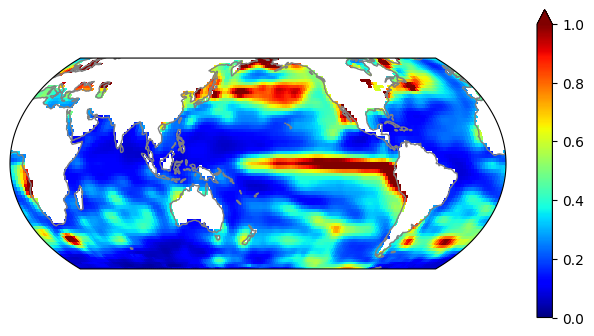

In [230]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    'transform': PlateCarree()
}

figvar = plt.figure(figsize=(8, 4))
axvar = plt.axes(projection=proj)
sstvar.plot(vmin=0, vmax=1, cmap='jet', **kwargs)
axvar.coastlines(color='.5')

In [231]:
sst_detrend_xa = sst_detrend_xa.where(sstvar < 2, drop=False)

In [232]:
testvar = sst_detrend_xa.var(dim=['time'], skipna=True)

/opt/coiled/env/lib/python3.11/site-packages/xarray/core/nputils.py:183: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


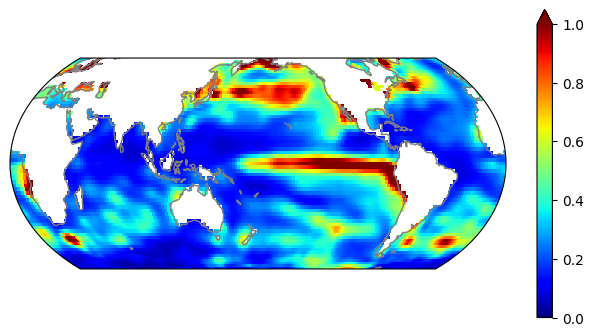

In [233]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    'transform': PlateCarree()
}

figvar = plt.figure(figsize=(8, 4))
axvar = plt.axes(projection=proj)
testvar.plot(vmin=0, vmax=1, cmap='jet', **kwargs)
axvar.coastlines(color='.5')

### Try a second linear detrend? 

In [140]:
# # Save index locations of elements which are NAN, replace them with 0 for now:
# boolar_isnan = np.isnan(sst_detrend)
# sst_detrend[boolar_isnan] = 0

In [141]:
# # Perform linear fit and subtract from data:
# fitresults = np.polyfit(x, sst_detrend, 1, rcond=None, full=False, w=None, cov=False)
# print(sst_detrend.shape)
# print(fitresults[1].shape)

# lintrend = sst_detrend*fitresults[0] + fitresults[1] 
# print(lintrend.shape)
# sst_detrend = sst_detrend - lintrend

## 3. EOF decomp

### 3.1 Using `eofs` package

Weight by latitude:

In [234]:
wgts = np.cos(np.deg2rad(sst_detrend_xa['lat']))

In [235]:
solver = Eof(
    sst_detrend, 
    weights = np.tile(wgts.values, (nlon, 1)).T
    )

/tmp/ipykernel_258/3491423890.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  solver = Eof(


In [252]:
eof1 = solver.eofs(neofs=10)
pc1  = solver.pcs(npcs=10, pcscaling=0)
varfrac = solver.varianceFraction()
lambdas = solver.eigenvalues()

In [253]:
varfrac

array([1.33961656e-01, 4.93072464e-02, 3.71169341e-02, ...,
       1.30001291e-32, 9.27160711e-33, 2.65562497e-33])

/tmp/ipykernel_258/3180226628.py:23: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig4.colorbar(p, ax=ax)
/tmp/ipykernel_258/3180226628.py:23: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig4.colorbar(p, ax=ax)
/tmp/ipykernel_258/3180226628.py:23: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig4.colorbar(p, ax=ax)
/tmp/ipykernel_258/3180226628.py:23: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set

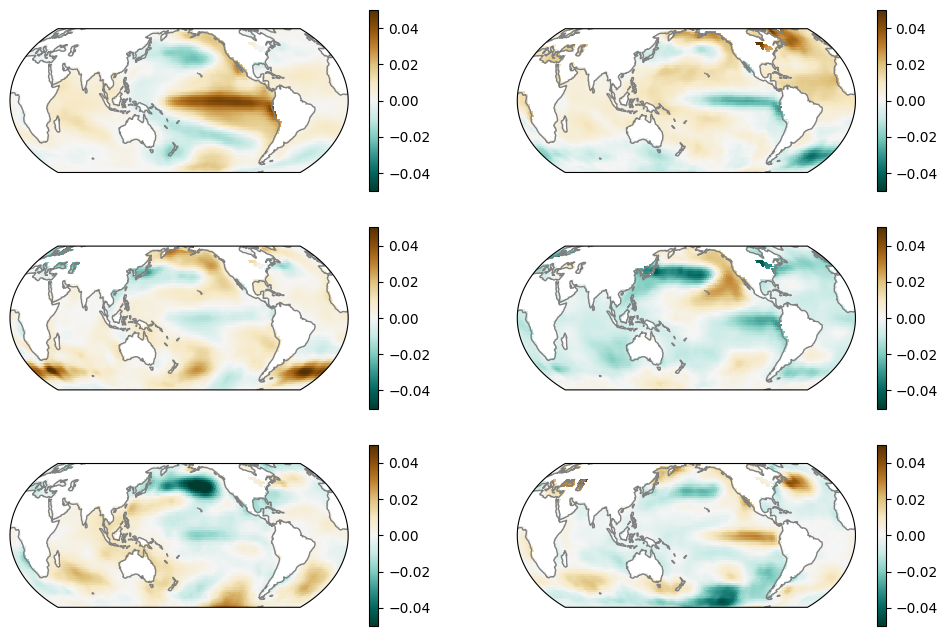

In [254]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    #'cmap' : 'RdBu', 'transform': PlateCarree()
    #'cmap' : 'RdYlBu_r', 'transform': PlateCarree()
    'cmap' : 'BrBG_r', 'transform': PlateCarree()
}

fig4 = plt.figure(figsize=(12, 8))

axes4 = []
for i in range(1, 7):
    axes4.append(plt.subplot(3, 2, i, projection=proj))

for ax in axes4:
    ax.coastlines(color='.5')
    
for i, ax in zip(range(6), axes4):
    p = ax.pcolor(
        sstdata['lon'], sstdata['lat'], eof1[i], 
        vmin=-0.05, vmax=0.05, 
        **kwargs
        )
    fig4.colorbar(p, ax=ax)

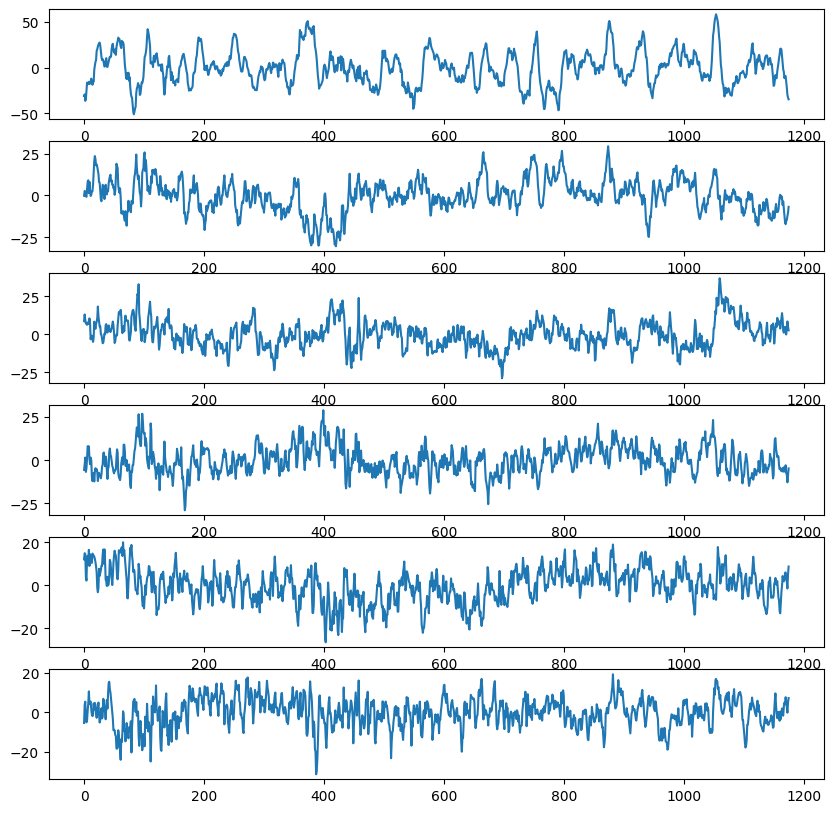

In [249]:
fig5, axes5 = plt.subplots(6, 1, figsize=(10,10))

for i, ax in zip(range(6), axes5):
    ax.plot(pc1[:,i])
    #ax.set_ylim(-0.1, 0.1)

### 3.2 Using `xeofs` package

In [240]:
wgts = np.cos(np.deg2rad(sst_detrend_xa['lat'])) # Weight by latitude

In [241]:
%%time

model = xe.models.EOF(
    n_modes=6,
    use_weights=True
    #use_coslat=True
    )
model.fit(sst_detrend_xa, dim='time', weights=wgts)

CPU times: user 505 ms, sys: 108 ms, total: 613 ms
Wall time: 611 ms


In [242]:
%%time

model.explained_variance_ratio().load()

CPU times: user 430 µs, sys: 5 µs, total: 435 µs
Wall time: 439 µs


<xarray.DataArray 'explained_variance_ratio' (mode: 6)>
array([0.17692043, 0.04968384, 0.04067876, 0.03343121, 0.03128962,
       0.02773461])
Coordinates:
  * mode     (mode) int64 1 2 3 4 5 6
Attributes:
    model:        EOF analysis
    n_modes:      6
    standardize:  False
    use_coslat:   False
    use_weights:  True
    solver:       auto
    software:     xeofs
    version:      1.1.0
    date:         2023-10-03 23:09:34

In [243]:
%%time

components = model.components().load()

CPU times: user 0 ns, sys: 2.85 ms, total: 2.85 ms
Wall time: 2.31 ms


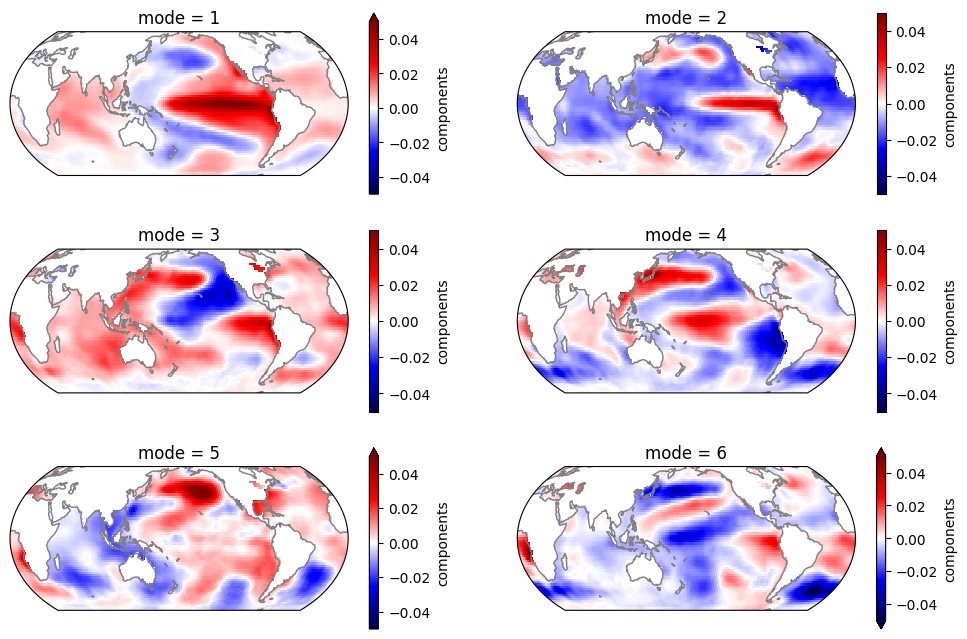

In [244]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    #'cmap' : 'RdBu', 'transform': PlateCarree()
    'cmap' : 'seismic', 'transform': PlateCarree()
}

fig4 = plt.figure(figsize=(12, 8))

axes4 = []
for i in range(1, 7):
    axes4.append(plt.subplot(3, 2, i, projection=proj))

for ax in axes4:
    ax.coastlines(color='.5')
    
for i, ax in zip(range(1,7), axes4):
    components.sel(mode=i).plot(ax=ax, vmin=-0.05, vmax=0.05, **kwargs)

In [245]:
%%time

scores = model.scores().load()

CPU times: user 519 µs, sys: 6 µs, total: 525 µs
Wall time: 529 µs


In [246]:
scores

<xarray.DataArray 'scores' (mode: 6, time: 1176)>
array([[-0.04916219, -0.04638316, -0.05739393, ..., -0.04700388,
        -0.05185172, -0.05479621],
       [-0.00085436,  0.00753869,  0.00673347, ..., -0.03679859,
        -0.03106417, -0.020364  ],
       [ 0.02914666,  0.04355365,  0.03209357, ...,  0.02821164,
         0.01663795,  0.00877369],
       [ 0.0199354 ,  0.00861846, -0.00671398, ...,  0.04668553,
         0.03170434,  0.0171116 ],
       [-0.04599033, -0.05675568, -0.05542814, ...,  0.00509668,
        -0.01928911, -0.03345765],
       [-0.02241954,  0.01474636,  0.02174738, ..., -0.00189174,
         0.01958994,  0.02824561]])
Coordinates:
  * time     (time) object 1910-01-01 00:00:00 ... 2007-12-01 00:00:00
  * mode     (mode) int64 1 2 3 4 5 6
Attributes:
    model:        EOF analysis
    n_modes:      6
    standardize:  False
    use_coslat:   False
    use_weights:  True
    solver:       auto
    software:     xeofs
    version:      1.1.0
    date:         2023-10-03 23:09:34

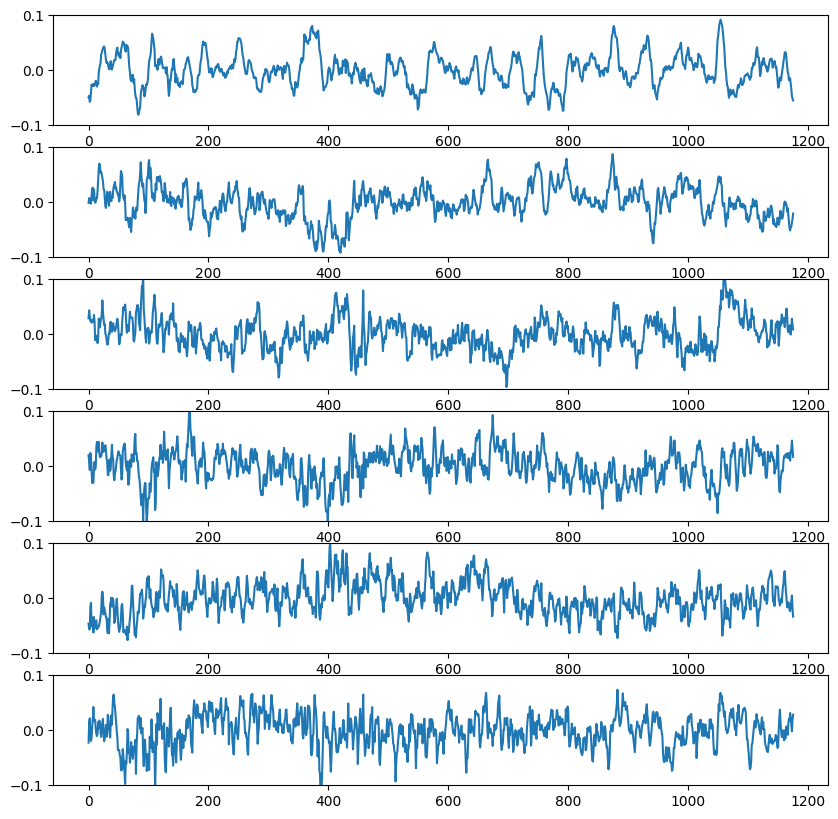

In [247]:
fig5, axes5 = plt.subplots(6, 1, figsize=(10,10))

for i, ax in zip(range(1, 7), axes5):
    ax.plot(scores.sel(mode=i).values)
    ax.set_ylim(-0.1, 0.1)

## 4. EOF decomp with Dask

### 4.1 Try first without cluster on the SST data without the detrending and cycle-removal

In [70]:
%%time

# EOF fit
model = xe.models.EOF(n_modes=10)
model.fit(sstdata['sst'], dim='time')

CPU times: user 322 ms, sys: 32.9 ms, total: 355 ms
Wall time: 10.3 s


In [71]:
%%time

model.explained_variance_ratio().load()

CPU times: user 42.2 ms, sys: 7.97 ms, total: 50.2 ms
Wall time: 1.17 s


<xarray.DataArray 'explained_variance_ratio' (mode: 10)>
array([0.86520344, 0.03153082, 0.02364369, 0.01467233, 0.00701139,
       0.00616689, 0.00445176, 0.00366635, 0.00301514, 0.00215666],
      dtype=float32)
Coordinates:
    lev      float64 0.0
  * mode     (mode) int64 1 2 3 4 5 6 7 8 9 10
Attributes:
    model:        EOF analysis
    n_modes:      10
    standardize:  False
    use_coslat:   False
    use_weights:  False
    solver:       auto
    software:     xeofs
    version:      1.1.0
    date:         2023-10-03 18:14:01

In [72]:
%%time

components = model.components().load()

CPU times: user 70.3 ms, sys: 7.65 ms, total: 78 ms
Wall time: 1.35 s


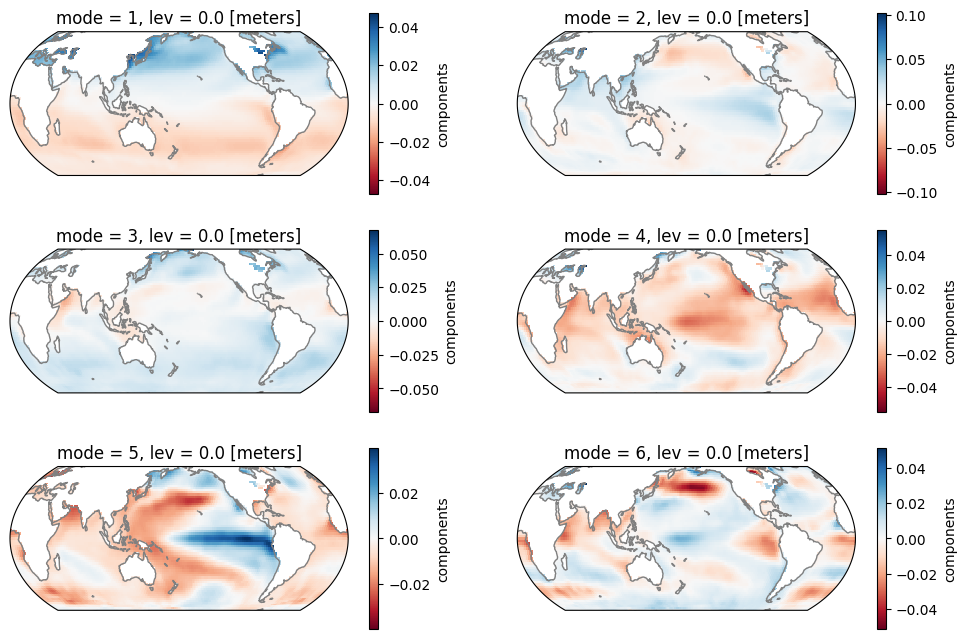

In [53]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    'cmap' : 'RdBu', 'transform': PlateCarree()
}

fig4 = plt.figure(figsize=(12, 8))

axes4 = []
for i in range(1, 7):
    axes4.append(plt.subplot(3, 2, i, projection=proj))

for ax in axes4:
    ax.coastlines(color='.5')
    
for i, ax in zip(range(1,7), axes4):
    components.sel(mode=i).plot(ax=ax, **kwargs)

### 4.2 Repeat with remote Coiled cluster

In [55]:
cluster = coiled.Cluster(n_workers=10, region='us-west-2')

Output()

Package - coiled_local_working, Built wheel does not contain all python files!

╭────────────────────────────────────────── Package Info ──────────────────────────────────────────╮
│                        ╷                                                                         │
│   Package              │ Note                                                                    │
│ ╶──────────────────────┼───────────────────────────────────────────────────────────────────────╴ │
│   coiled_local_synced  │ Source wheel built from /scratch/synced                                 │
│   coiled_local_working │ Source wheel built from                                                 │
│                        │ /opt/coiled/rt/.path-deps/coiled_local_working-0.0.0-py3-none-any.whl   │
│                        ╵                                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── Not Synced with Cluster ─────────────────────────────────────╮
│                            ╷                                                        ╷            │
│   Package                  │ Error                                                  │ Risk       │
│ ╶──────────────────────────┼────────────────────────────────────────────────────────┼──────────╴ │
│   coiled_local_working     │ Built wheel does not contain all python files!         │ Warning    │
│                            ╵                                                        ╵            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

In [58]:
client = cluster.get_client()

In [59]:
client

<Client: 'tls://10.0.59.28:8786' processes=10 threads=40, memory=148.38 GiB>

In [54]:
# ## Testing with a local cluster
# from dask.distributed import Client, LocalCluster
# client = Client()
# client

In [77]:
# Test first a simple dask computation:
sstdata['ssta'].mean().compute()

/opt/coiled/env/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 124.04 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<xarray.DataArray 'ssta' ()>
array(-0.23983575, dtype=float32)
Coordinates:
    lev      float64 0.0

In [82]:
#sst_chunkedbetter = sstdata['sst'].chunk({'time':300, 'lat':89, 'lon':180})
sst_chunkedbetter = sstdata['sst'].chunk({'time':900})

In [83]:
sst_chunkedbetter

<xarray.DataArray 'sst' (time: 1176, lat: 89, lon: 180)>
dask.array<rechunk-merge, shape=(1176, 89, 180), dtype=float32, chunksize=(900, 89, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
    lev      float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1910-01-01 00:00:00 ... 2007-12-01 00:00:00
Attributes:
    long_name:      Extended reconstructed sea surface temperature
    standard_name:  sea_surface_temperature
    units:          degree_C
    valid_min:      -3.0
    valid_max:      45.0

In [85]:
%%time

# EOF fit
model = xe.models.EOF(n_modes=10)
#model.fit(sstdata['sst'], dim='time')
model.fit(sst_chunkedbetter, dim='time')

/opt/coiled/env/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 123.94 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/coiled/env/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 123.94 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/coiled/env/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 123.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/coiled/env/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 123.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/coiled/env/lib/python3.11/site-packages/distributed/client.py:3161: Use

CPU times: user 4.19 s, sys: 1.58 s, total: 5.77 s
Wall time: 2min 23s


In [ ]:
# Timechunk=1: time = 2 min 42 sec

In [44]:
%%time

model.explained_variance_ratio().load()

CPU times: user 10.2 s, sys: 1.12 s, total: 11.3 s
Wall time: 9.85 s


<xarray.DataArray 'explained_variance_ratio' (mode: 10)>
array([0.84958625, 0.030128  , 0.02025557, 0.00976711, 0.00581182,
       0.00389102, 0.0022602 , 0.00170364, 0.00154415, 0.00129905],
      dtype=float32)
Coordinates:
    lev      float64 0.0
  * mode     (mode) int64 1 2 3 4 5 6 7 8 9 10
Attributes:
    model:        EOF analysis
    n_modes:      10
    standardize:  False
    use_coslat:   False
    use_weights:  False
    solver:       auto
    software:     xeofs
    version:      1.1.0
    date:         2023-10-03 17:02:01

In [45]:
%%time

components = model.components().load()

CPU times: user 9.14 s, sys: 765 ms, total: 9.9 s
Wall time: 8.88 s


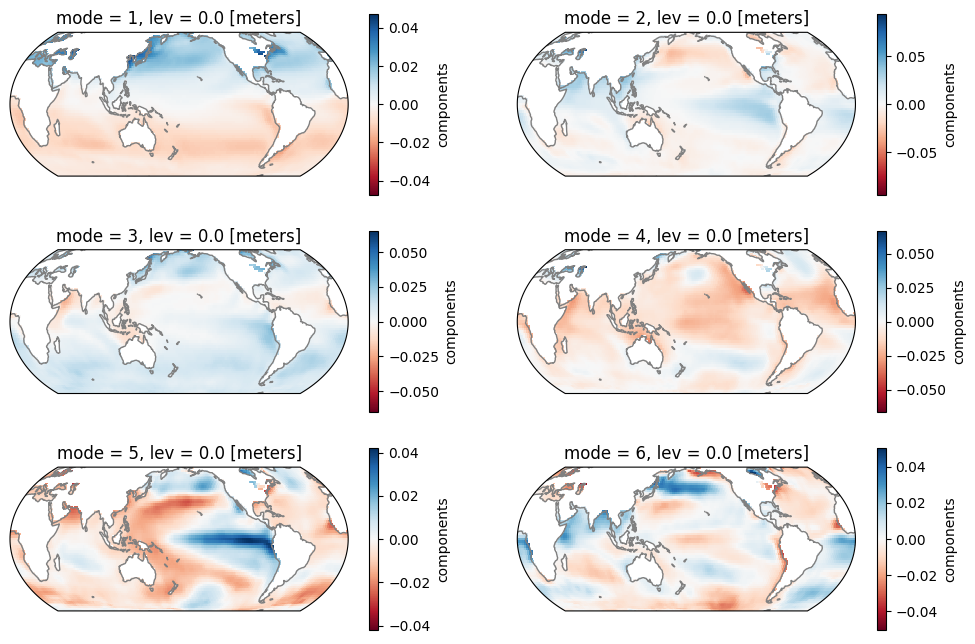

In [46]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    'cmap' : 'RdBu', 'transform': PlateCarree()
}

fig4 = plt.figure(figsize=(12, 8))

axes4 = []
for i in range(1, 7):
    axes4.append(plt.subplot(3, 2, i, projection=proj))

for ax in axes4:
    ax.coastlines(color='.5')
    
for i, ax in zip(range(1,7), axes4):
    components.sel(mode=i).plot(ax=ax, **kwargs)

In [86]:
client.shutdown()

## Appendix A: checking for nan's in the dataset

!This section reloads the data!

In [ ]:
sstdata = xr.open_mfdataset(fileobjs_good, chunks={})

In [ ]:
sstdata = sstdata.squeeze()
sst = sstdata['sst'].values

In [68]:
anan = []
for i in range(sst.shape[0]):
    anan.append(np.argwhere(np.isnan(sst)[i]).shape)

In [74]:
anan[0]

(3952, 2)

In [69]:
print(anan[0] == anan[1])

True


In [70]:
for a in anan:
    if a != anan[0]:
        print('flag!')